In [1]:
import torch 
import pandas as pd
import numpy as np
from amlvae.models.VAE import VAE

import shap
from matplotlib import pyplot as plt
import gseapy as gp
import umap 
import seaborn as sbn

from captum.attr import IntegratedGradients
from captum.attr import GradientShap

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('../output/vae_l12_4-21-25.pt', weights_only=False)

model = model.to(device)
model.eval()

expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32, device=device)


In [3]:
expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32, device=device)

In [4]:
class LatentFeatureExtractor(torch.nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device

    def set_latent_idx(self, idx):
        self.latent_idx = idx

    def forward(self, X):
        z, _ = self.model.encode(X)
        return z[:, [self.latent_idx]]

# Instantiate the module
f = LatentFeatureExtractor(model=model, device=device)

In [5]:
z0 = torch.zeros(1,12).to(device)
x0 = model.decode(z0)
z0hat = model.encode(x0)[0]
err = torch.mean((z0hat - z0)**2)
print(err.item())

0.027367815375328064


In [11]:
gseas = [] 
for i in range(12): 
    print(i, end='\r')
    
    z0 = torch.zeros(1,12).to(device)
    xb = x0.expand(X.shape[0], -1)
    f.set_latent_idx(i)

    integrated_gradients = IntegratedGradients(f)
    importance_scores = integrated_gradients.attribute(X, baselines=xb, n_steps=100).detach().cpu().numpy()

    scores = importance_scores.mean(0)
    argixs = np.argsort( scores )
    gene_order = expr.columns[1:]

    # sort high to low 
    argixs = argixs[::-1]

    sorted_scores = scores[argixs]
    sorted_genes = list(gene_order[argixs])

    # prepare pre-ranked list for GSEA
    rnk = pd.DataFrame({
        'gene': sorted_genes,
        'score': sorted_scores
    }).set_index('gene')

    # run prerank GSEA with Reactome_2016
    prerank_res = gp.prerank(
        rnk=rnk,
        gene_sets=["Reactome_2016"],
        outdir=None,         # don't write files to disk
        permutation_num=1000, 
        seed=0
    )

    gseas.append(prerank_res.res2d)

In [365]:
 # select top 200 genes 
top_genes = sorted_genes[:300]

enr_bg = gp.enrichr(
    gene_list=top_genes,
    gene_sets=["Reactome_2016"],
    background=sorted_genes,
    outdir=None
)

enr_bg.results.head(5)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Cellular Senescence Homo sapiens R-HSA-2559583,0.030440,0.932,0,0,9.445946,32.985371,CCNA1;CXCL8;CBX2;ID1
1,Reactome_2016,Formation of Fibrin Clot (Clotting Cascade) Ho...,0.046502,0.932,0,0,3.551020,10.895467,VWF;SERPING1;PRTN3;TFPI;CD177;F5
2,Reactome_2016,Assembly of collagen fibrils and other multime...,0.069873,0.932,0,0,4.716216,12.550208,COL24A1;COL6A1;COL4A5;MMP9
3,Reactome_2016,Phase II conjugation Homo sapiens R-HSA-156580,0.069873,0.932,0,0,4.716216,12.550208,GGT5;HPGDS;UGT2B11;SULT1C4
4,Reactome_2016,Regulation of Complement cascade Homo sapiens ...,0.083283,0.932,0,0,7.060606,17.549202,CFH;C5AR1;C3AR1


In [16]:
for i,res in enumerate(gseas): 
    n_sig = res[res['FDR q-val'] < 0.05].shape[0] 
    top3_most_sig_terms = res.sort_values('FDR q-val').head(3).Term.tolist()
    print(f"Latent {i}: # sig pathways = {n_sig}")
    if n_sig > 0: 
        print('\t', top3_most_sig_terms)  
    else: 
        print(f"Latent {i}: No significant pathways")
    print() 

Latent 0: # sig pathways = 0
Latent 0: No significant pathways

Latent 1: # sig pathways = 6
	 ['Reactome_2016__MHC class II antigen presentation Homo sapiens R-HSA-2132295', 'Reactome_2016__Costimulation by the CD28 family Homo sapiens R-HSA-388841', 'Reactome_2016__TCR signaling Homo sapiens R-HSA-202403']

Latent 2: # sig pathways = 1
	 ['Reactome_2016__Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell Homo sapiens R-HSA-198933', 'Reactome_2016__MyD88 cascade initiated on plasma membrane Homo sapiens R-HSA-975871', 'Reactome_2016__Toll Like Receptor 10 (TLR10) Cascade Homo sapiens R-HSA-168142']

Latent 3: # sig pathways = 0
Latent 3: No significant pathways

Latent 4: # sig pathways = 24
	 ['Reactome_2016__GTP hydrolysis and joining of the 60S ribosomal subunit Homo sapiens R-HSA-72706', 'Reactome_2016__Eukaryotic Translation Initiation Homo sapiens R-HSA-72613', 'Reactome_2016__Cap-dependent Translation Initiation Homo sapiens R-HSA-72737']

Latent 5: # sig 

In [ ]:
# DEPRECATED FROM HERE 

In [325]:
class VaeExplainer: 
    def __init__(self, func, X, gene_order, n_bg=200): 
        self.func = func
        self.X = X
        self.n_bg = n_bg
        self.gene_order = gene_order

        self.xb, self.xg = self.get_bg()

    def get_bg(self):
        bg_mask = torch.rand(X.shape[0]) < (self.n_bg / X.shape[0])
        fg_mask = ~bg_mask
        xb = X[bg_mask]
        xx = X[fg_mask] 

        return xb, xx

    def explain(self, idx, method='shap', permutations=10, verbose=True, absval=False):

        scores = [] 
        for i in range(permutations): 
            if verbose: 
                print(f'attribution [{method}] -> {i}/{permutations}', end='\r')
            s = self.explain_(idx, method=method)
            if absval: 
                s = np.abs(s)
            scores.append(s.mean(0)) # NOTE: averaging over samples
        scores = np.stack(scores, 0).mean(0) # average of permutations
        return scores

    def explain_(self, idx, method='shap'): 

        self.func.set_latent_idx(idx)

        #xb, xx = self.get_bg()
        xb = self.xb
        xx = self.xg

        if method == 'shap': 
            gradient_shap = GradientShap(self.func)
            importance_scores =  gradient_shap.attribute(xx, 
                                          n_samples=50,
                                          stdevs=0.0001,
                                          target=0,
                                          baselines=xx).detach().cpu().numpy()
            return importance_scores
        elif method == 'ig': 
            integrated_gradients = IntegratedGradients(self.func)
            importance_scores = integrated_gradients.attribute(xx, baselines=xx*0, n_steps=300).detach().cpu().numpy()
            return importance_scores
        else: 
            raise ValueError("Unknown method: {}".format(method))
        
    def ora(self, scores, q=0.9, gene_sets=['Reactome_2016']):

        
        # get the top q% of genes
        threshold = np.quantile(scores, q)
        top_genes = np.where(scores >= threshold)[0]

        # get the gene names
        top_gene_names = list(self.gene_order[top_genes])

        enr_bg = gp.enrichr(
            gene_list=top_gene_names,
            gene_sets=gene_sets,
            background=self.gene_order,
            outdir=None
        )

        return enr_bg
        
    
    def gsea(self, scores, gene_sets=['Reactome_2016'], n_permutations=1000, seed=np.random.randint(0, 10000)):

        argixs = np.argsort( scores )

        # sort high to low 
        argixs = argixs[::-1]

        sorted_scores = scores[argixs]
        sorted_genes = self.gene_order[argixs]

        # prepare pre-ranked list for GSEA
        rnk = pd.DataFrame({
            'gene': sorted_genes,
            'score': sorted_scores
        }).set_index('gene')

        # run prerank GSEA with Reactome_2016
        prerank_res = gp.prerank(
            rnk=rnk,
            gene_sets=gene_sets,
            outdir=None,         # don't write files to disk
            permutation_num=n_permutations, 
            seed=seed
        )

        return prerank_res


In [326]:
explainer = VaeExplainer(f, X, expr.columns[1:], n_bg=50)

In [ ]:
shap_values = explainer.explain(0, method='shap', permutations=1)
shap_values2 = explainer.explain(0, method='shap', permutations=1)

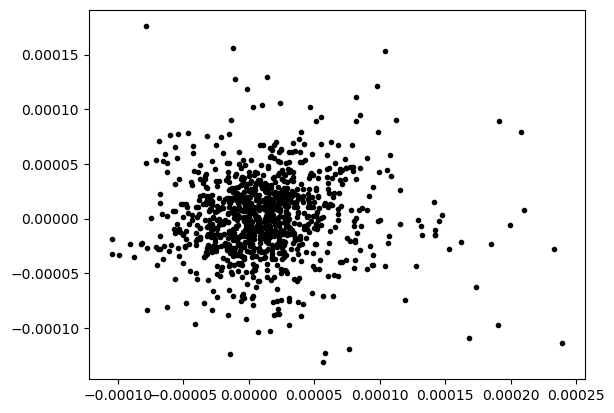

In [328]:
plt.figure() 
plt.plot(shap_values, shap_values2, 'k.')
plt.show()

In [289]:
intg_values = explainer.explain(0, method='ig', permutations=1) 
intg_values2 = explainer.explain(0, method='ig', permutations=1) 

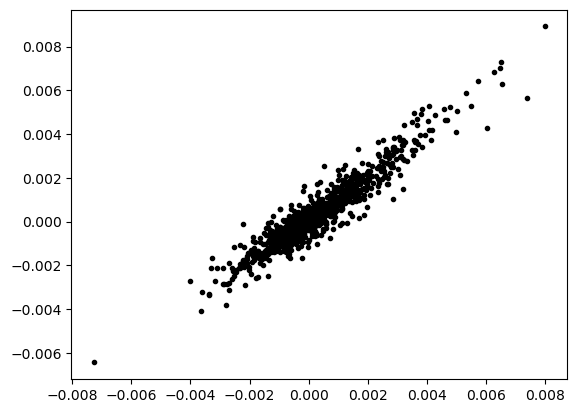

In [290]:
plt.figure() 
plt.plot(intg_values, intg_values2, 'k.')
plt.show()

shap vs ig corr (gene attribution): 0.09117029904733176


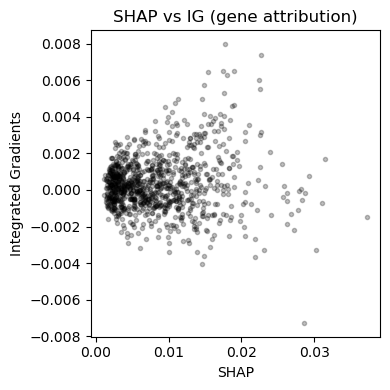

In [291]:
print('shap vs ig corr (gene attribution):', np.corrcoef(shap_values.ravel(), intg_values.ravel())[0, 1])

fig, axes = plt.subplots(1, 1, figsize=(4,4))

# First plot
axes.plot(shap_values.ravel(), intg_values.ravel(), 'k.', alpha=0.25)
axes.set_xlabel('SHAP')
axes.set_ylabel('Integrated Gradients')
axes.set_title('SHAP vs IG (gene attribution)')

plt.tight_layout()
plt.show()

In [292]:
gsea_shap = explainer.gsea(shap_values, gene_sets=['Reactome_2016'], n_permutations=1000) 
gsea_ig = explainer.gsea(intg_values, gene_sets=['Reactome_2016'], n_permutations=1000)

shap vs ig log(pval) corr: -0.31601769263078083


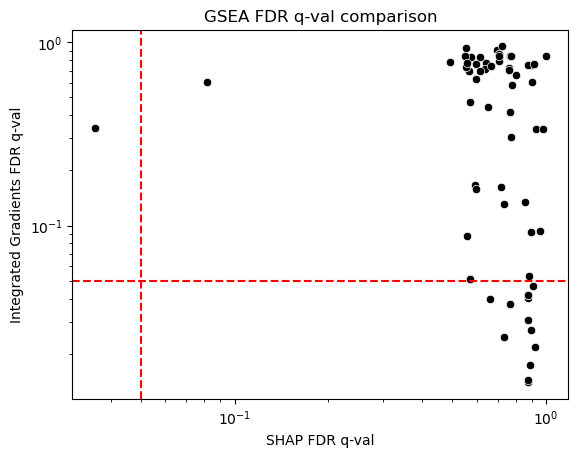

In [293]:
gsea_both = gsea_shap.res2d[['Term', 'FDR q-val']].merge(gsea_ig.res2d[['Term', 'FDR q-val']], on='Term', suffixes=('_shap', '_ig'))

print('shap vs ig log(pval) corr:', gsea_both[['FDR q-val_shap', 'FDR q-val_ig']].corr().values[0,1])

plt.figure() 
sbn.scatterplot(x='FDR q-val_shap', y='FDR q-val_ig', data=gsea_both, color='k')
plt.axvline(0.05, color='r', linestyle='--')
plt.axhline(0.05, color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SHAP FDR q-val')
plt.ylabel('Integrated Gradients FDR q-val')
plt.title('GSEA FDR q-val comparison')
plt.show() 

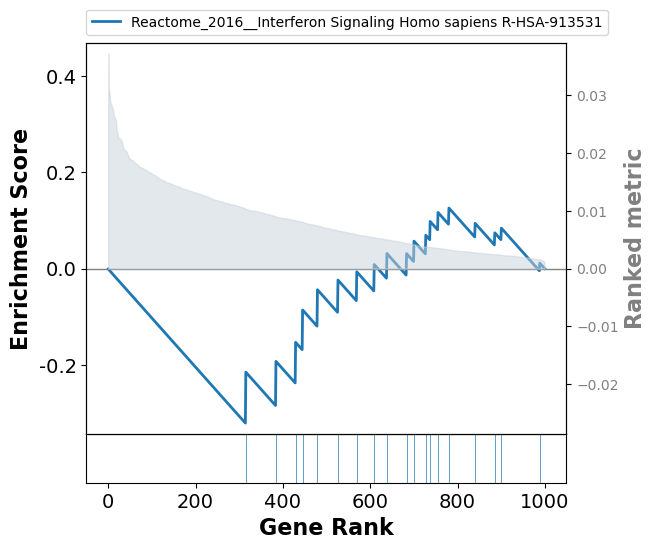

In [294]:
axs = gsea_shap.plot(terms=gsea_shap.res2d[lambda x: x['FDR q-val'] < 0.05].Term.values,
                       show_ranking=True, 
                       figsize=(6,6)) # v1.0.5

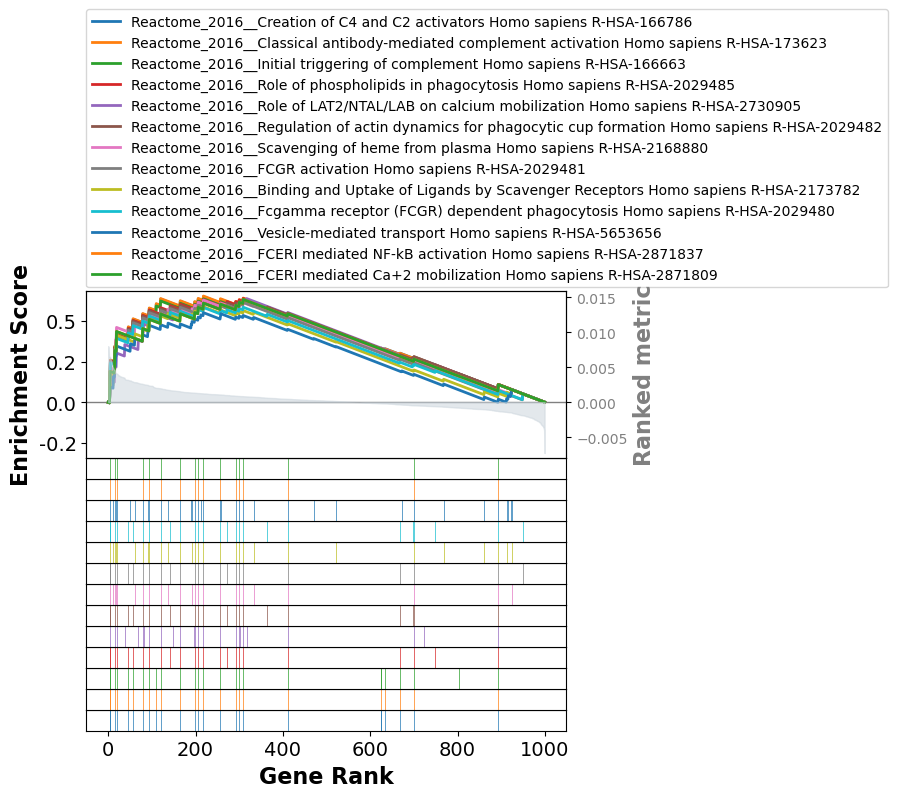

In [295]:
axs = gsea_ig.plot(terms=gsea_ig.res2d[lambda x: x['FDR q-val'] < 0.05].Term.values,
                       show_ranking=True, 
                       figsize=(6,6)) # v1.0.5

##################
latent feature 0
##################


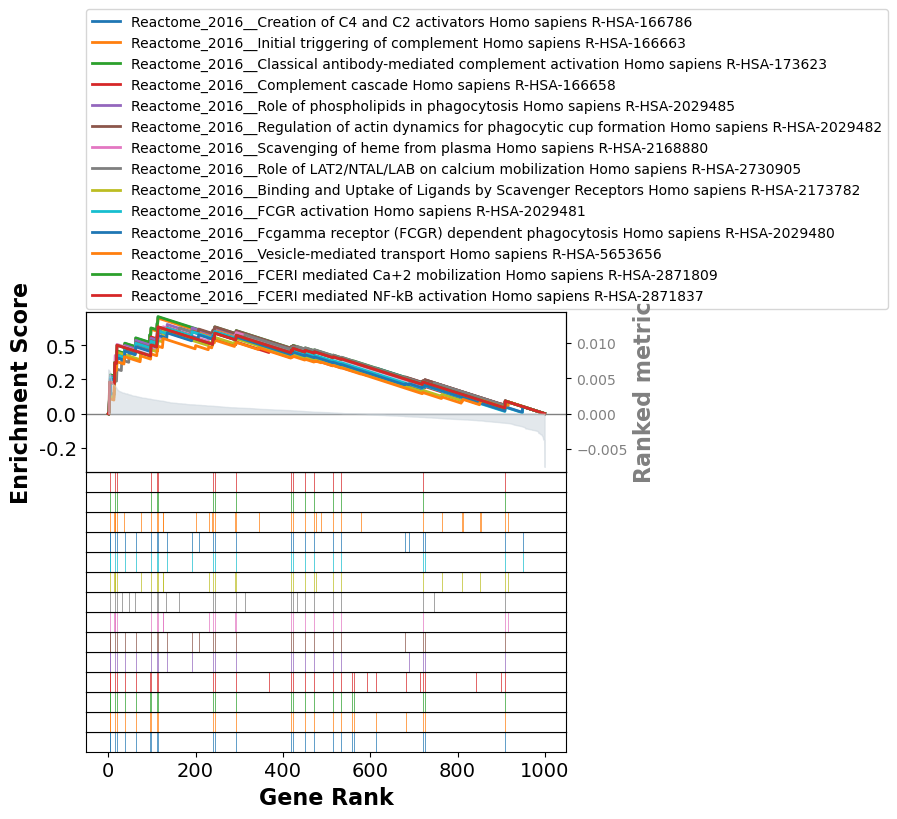

##################
##################
latent feature 1
##################


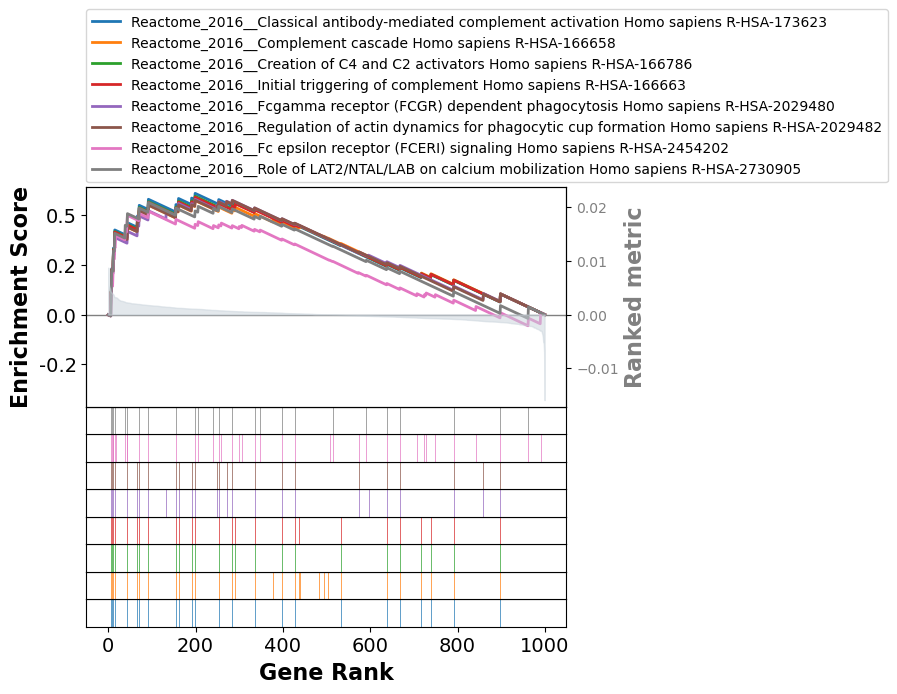

##################
##################
latent feature 2
##################


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/gseapy/plot.py:1509: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc=(0, 1.02))


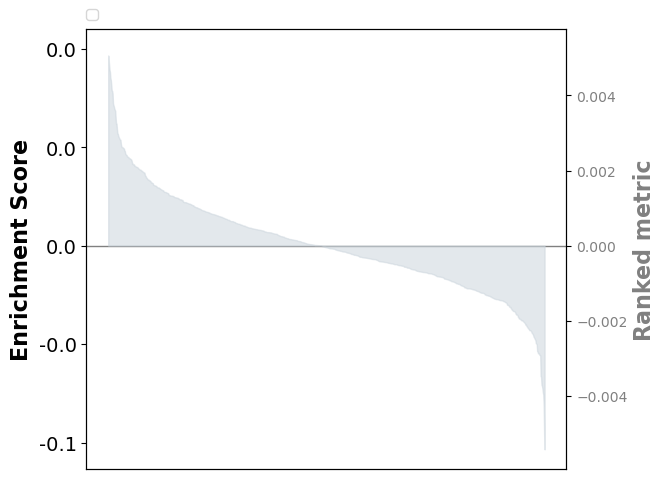

##################
##################
latent feature 3
##################


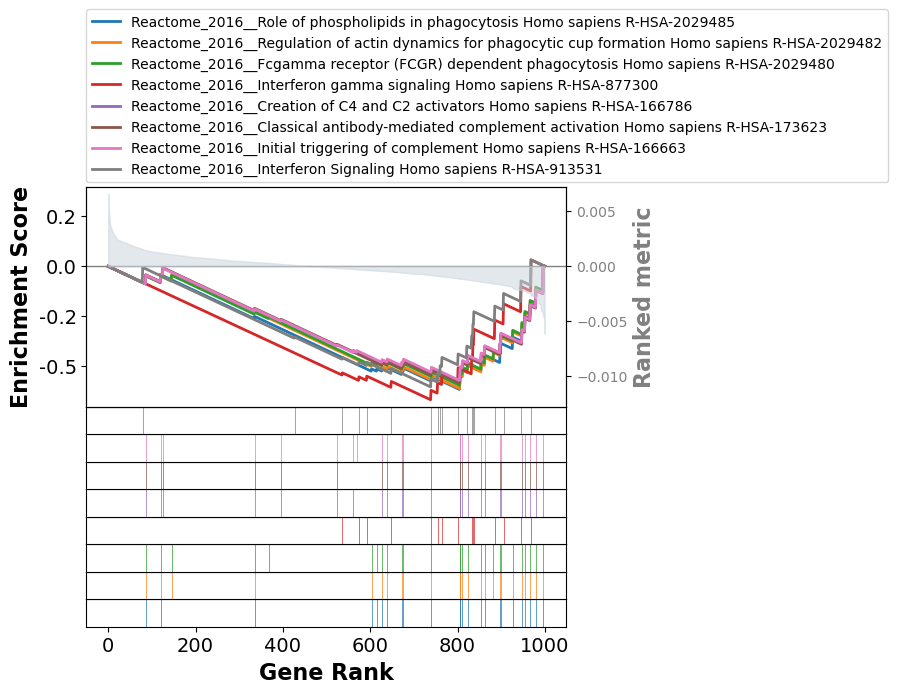

##################
##################
latent feature 4
##################


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/gseapy/plot.py:1509: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc=(0, 1.02))


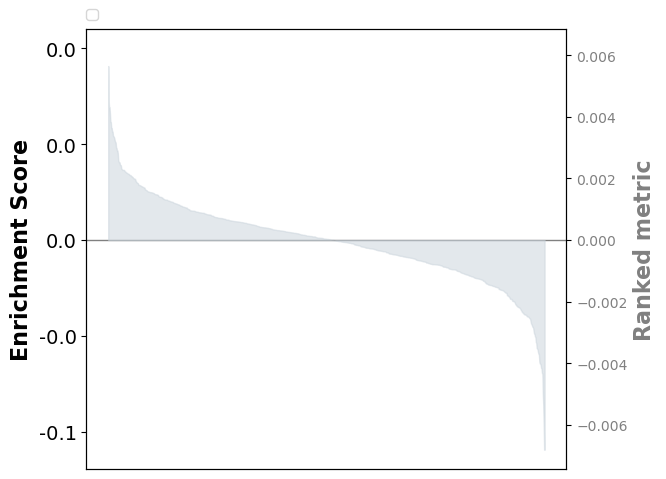

##################
##################
latent feature 5
##################


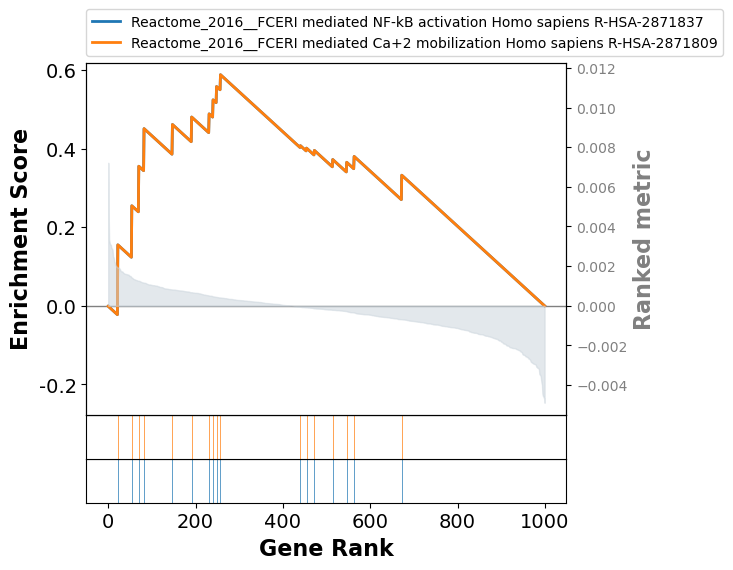

##################
##################
latent feature 6
##################


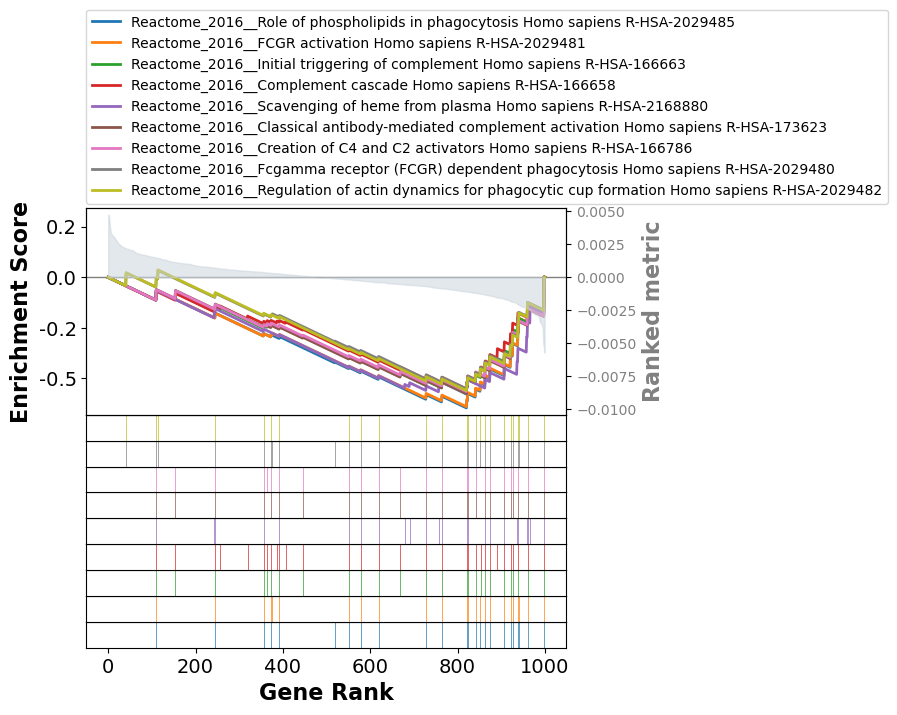

##################
##################
latent feature 7
##################


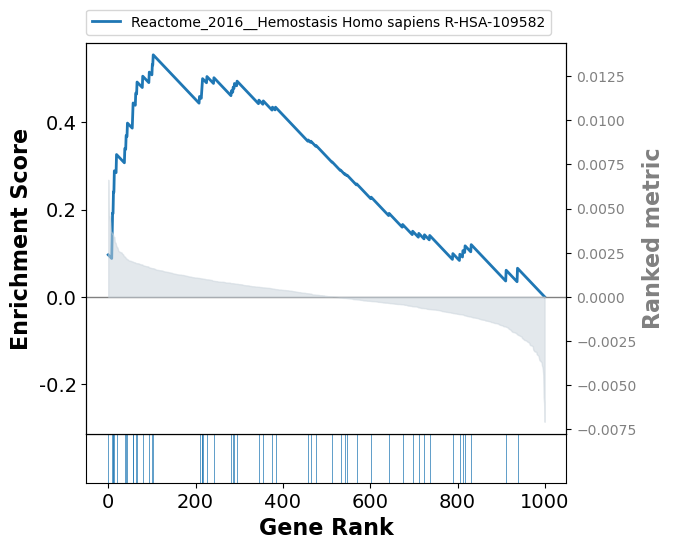

##################
##################
latent feature 8
##################


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/gseapy/plot.py:1509: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc=(0, 1.02))


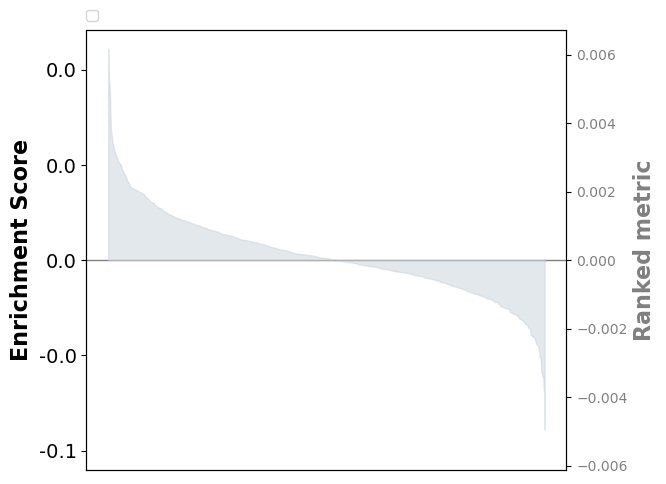

##################
##################
latent feature 9
##################


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/gseapy/plot.py:1509: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc=(0, 1.02))


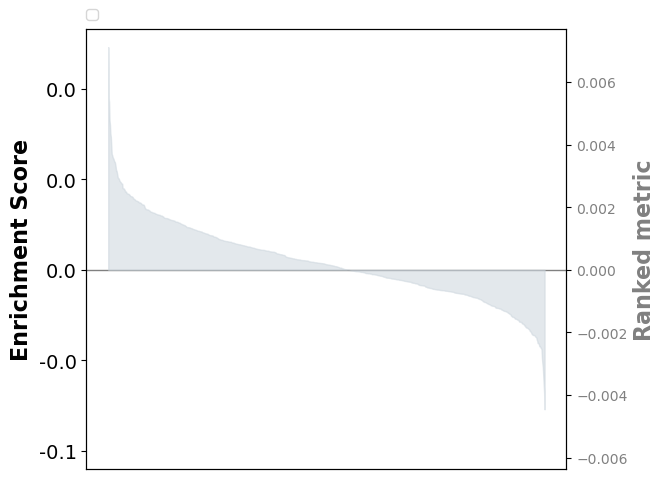

##################
##################
latent feature 10
##################


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/gseapy/plot.py:1509: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(loc=(0, 1.02))


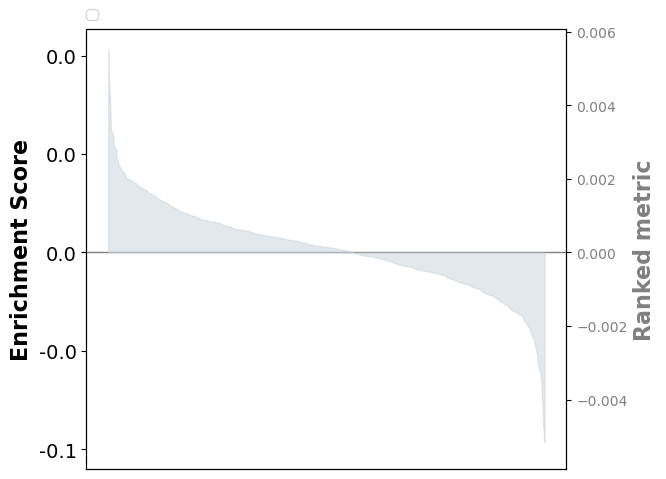

##################
##################
latent feature 11
##################


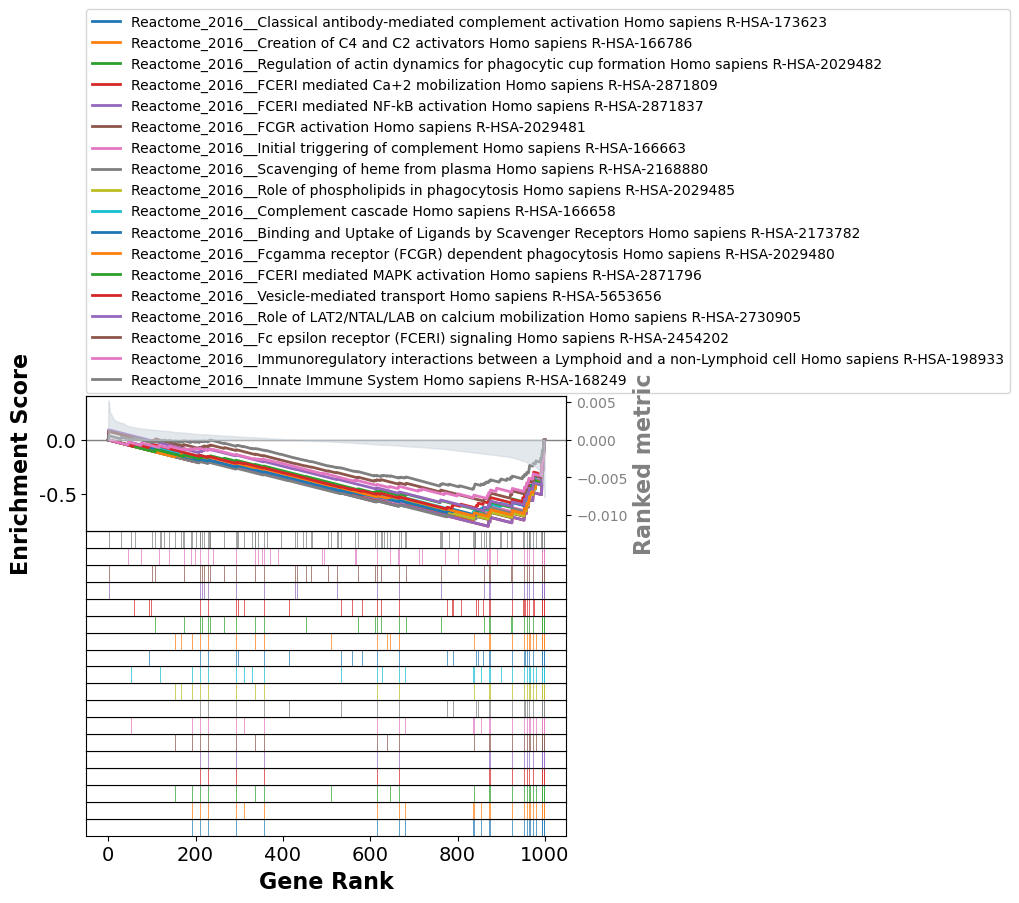

##################


In [296]:
for i in range(12): 
    print('##################')
    print(f'latent feature {i}')
    print('##################')
    scores = explainer.explain(i, method='ig', permutations=1)
    gsea = explainer.gsea(scores, gene_sets=['Reactome_2016'], n_permutations=5000)

    axs = gsea.plot(terms=gsea.res2d[lambda x: x['FDR q-val'] < 0.05].Term.values,
                       show_ranking=True, 
                       figsize=(6,6)) # v1.0.5 
    plt.show()
    
    print('##################')
    

In [61]:
genelist = sorted_genes[:50].tolist()
background = expr.columns[1:].tolist()

enr_bg = gp.enrichr(gene_list=genelist,
                gene_sets=['Reactome_2016'],
                # organism='human', # organism argment is ignored because user input a background
                background=background,
                outdir=None, # don't write to disk
                )

In [62]:
enr_bg.results.head(10)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,HDMs demethylate histones Homo sapiens R-HSA-3...,0.002452,0.203845,0,0,inf,inf,KDM5D;UTY
1,Reactome_2016,Chromatin organization Homo sapiens R-HSA-4839726,0.022248,0.203845,0,0,13.152778,50.053140,KDM5D;UTY
2,Reactome_2016,Chromatin modifying enzymes Homo sapiens R-HSA...,0.022248,0.203845,0,0,13.152778,50.053140,KDM5D;UTY
3,Reactome_2016,Platelet Aggregation (Plug Formation) Homo sap...,0.032313,0.203845,0,0,9.854167,33.822455,GP9;ITGA2B
4,Reactome_2016,Infectious disease Homo sapiens R-HSA-5663205,0.032313,0.203845,0,0,9.854167,33.822455,CD9;RPS4Y1
5,Reactome_2016,Glycosaminoglycan metabolism Homo sapiens R-HS...,0.043807,0.203845,0,0,7.875000,24.632667,B3GNT7;SDC4
6,Reactome_2016,"Platelet activation, signaling and aggregation...",0.046572,0.203845,0,0,3.355072,10.289194,GP9;MMRN1;ITGA2B;CD9
7,Reactome_2016,Sperm:Oocyte Membrane Binding Homo sapiens R-H...,0.050000,0.203845,0,0,inf,inf,CD9
8,Reactome_2016,Fertilization Homo sapiens R-HSA-1187000,0.050000,0.203845,0,0,inf,inf,CD9
9,Reactome_2016,Reproduction Homo sapiens R-HSA-1474165,0.050000,0.203845,0,0,inf,inf,CD9


In [ ]:
def get_latent_explanation_pathway_enrichment(i, X, n_background=100, samples=500, genes=None, top_q=0.9):

    xx = X[i, :].reshape(1, -1)
    background_candidates = [j for j in range(X.shape[0]) if j != i]
    background_ixs = np.random.choice(background_candidates, n_background, replace=False)
    xx_background = X[background_ixs, :]
    explainer = shap.KernelExplainer(f, xx_background) 
    shap_values = explainer.shap_values(xx, nsamples=samples)
    df = pd.DataFrame({'abs_mean_shap':np.abs( shap_values ).mean(-1).ravel(),
                       'genes':genes})
    genelist = df[lambda x: x.abs_mean_shap >= np.quantile(df.abs_mean_shap, top_q)].genes.values.tolist()
    background = df.genes.values.tolist()
    
    enr_bg = gp.enrichr(gene_list=genelist,
                    gene_sets=['Reactome_2016'],
                    # organism='human', # organism argment is ignored because user input a background
                    background=background,
                    outdir=None, # don't write to disk
                    )

    return df, enr_bg.results 


In [ ]:
i = 1
shap_df1, enr_df1 = get_latent_explanation_pathway_enrichment(i, X, n_background=100, samples=500, genes=expr.columns[1:], top_q=0.95)
shap_df2, enr_df2 = get_latent_explanation_pathway_enrichment(i, X, n_background=100, samples=500, genes=expr.columns[1:], top_q=0.95)
enr_df_ = enr_df1.merge(enr_df2, on='Term', how='inner') 

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 1000, 12)


Exception: Error getting the Enrichr libraries

In [ ]:
enr_df1.head()

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,GPVI-mediated activation cascade Homo sapiens ...,0.002452,0.274670,0,0,inf,inf,FCER1G;IL2RA
1,Reactome_2016,Cell surface interactions at the vascular wall...,0.048743,0.742822,0,0,4.267477,12.892889,FCER1G;OLR1;CEACAM8
2,Reactome_2016,The canonical retinoid cycle in rods (twilight...,0.050000,0.742822,0,0,inf,inf,DHRS9
3,Reactome_2016,Synthesis and interconversion of nucleotide di...,0.050000,0.742822,0,0,inf,inf,AK5
4,Reactome_2016,Smooth Muscle Contraction Homo sapiens R-HSA-4...,0.050000,0.742822,0,0,inf,inf,DYSF


In [ ]:
enr_df2.head()


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2016,Regulation of Complement cascade Homo sapiens ...,0.013788,0.322412,0,0,19.750000,84.608665,CR1;C3AR1
1,Reactome_2016,"Transport of glucose and other sugars, bile sa...",0.032313,0.322412,0,0,9.854167,33.822455,SLC40A1;SLC2A5
2,Reactome_2016,Netrin-1 signaling Homo sapiens R-HSA-373752,0.050000,0.322412,0,0,inf,inf,DOCK1
3,Reactome_2016,DCC mediated attractive signaling Homo sapiens...,0.050000,0.322412,0,0,inf,inf,DOCK1
4,Reactome_2016,TRP channels Homo sapiens R-HSA-3295583,0.050000,0.322412,0,0,inf,inf,TRPM4


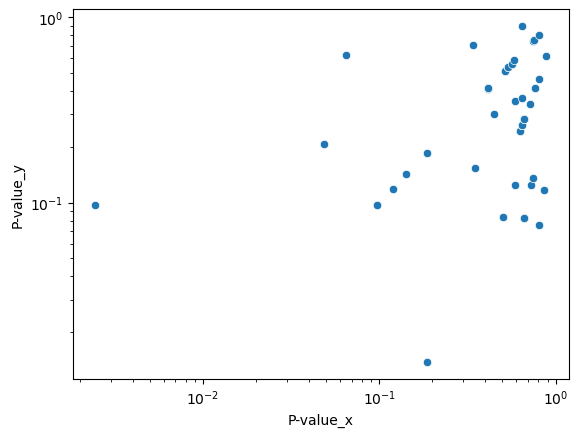

In [ ]:
plt.figure()
sbn.scatterplot(data=enr_df_, x='P-value_x', y='P-value_y') 
plt.xscale('log')
plt.yscale('log')
plt.show()